Demonstrate the idea of using the physical model to compensate for areas where we dont have much data, which could be because of data acquisition causing a bottleneck (so data is collected where we expect large variations) or just due to missing data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [4]:
len(pch)

23

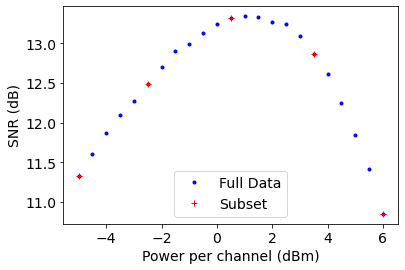

In [5]:
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed

In [303]:
def shift_pch(pch, shift):
    pch_shifted = pch - shift
    print("Power shift: %.3f" % shift)
    return pch_shifted
def gen_phys_targets(model, pch, num_pts_phys, sig, rseed):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    snr_phys = (predict_snr_pvar(pch_gn_shifted, model, rseed, sig)).reshape(-1,1)
    return pch_gn_shifted, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_to_dbm(x):
    return 10*np.log10(x/1e-3)
def convert_to_lin_dbm(x):
    return 1e-3*convert_to_lin(x)
def predict_snr_pvar(pch, model, rseed, sig):
    np.random.seed(rseed)
    #pch_pert = convert_to_dbm( np.array([np.random.normal(i, sig) for i in convert_to_lin_dbm(pch)]) )
    try:
        pch_pert = pch + np.random.normal(0, sig, len(pch))
    except:
        pch_pert = pch + np.random.normal(0, sig, 1)
    #pch_pert = pch + np.random.uniform(-sig, sig, len(pch))
    ASE = phys_model.calc_Pase() # W
    Pnli = phys_model.calc_eta(pch_pert)*(convert_to_lin_dbm(pch_pert)**3)
    #trx_btb = 1/31.6
    #trx_btb = 1/39.8
    trx_btb = 1/convert_to_lin(16.)
    return convert_to_db(1/(1/(convert_to_lin_dbm(pch_pert)/(ASE + Pnli)) + trx_btb ))

G.652 fibre: D 13.3 -> 18.6 ps/nm/km, max $\alpha=0.3$ dB/km   

In [391]:
place_holder = 100
phys_model = GN_model(100, 1550, 1, 0.72, 14, 0.20, 35, 40.2, 50, 4.4, 10, place_holder, place_holder, 4) # G.652 +1 dBm shift
#phys_model = GN_model(100, 1550, 1, 0.72, 17, 0.2, 35, 40.2, 50, 4.6, 10, place_holder, place_holder, 4) # G.652 no shift
#phys_model = GN_model(100, 1550, 1, 1.14, 13.3, 0.18, 35, 40.2, 50, 4.6, 10, place_holder, place_holder, 4) # G.652 +3 dBm shift

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [392]:
shift = +1
pch_sub_shifted = shift_pch(pch_sub, shift)
pch_shifted = shift_pch(pch, shift)
pch_gn_example, snr_phys_example = gen_phys_targets(phys_model, pch_shifted, len(snr), 0.01, 3)
print(str(pch_shifted[0]) + ' -> ' + str(pch_shifted[-1]))

Power shift: 1.000
Power shift: 1.000
-6.0 -> 5.0


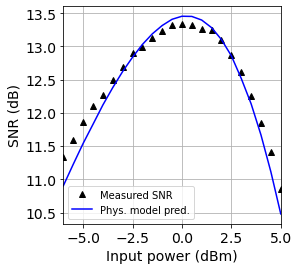

In [393]:
f, ax = plt.subplots()
plt.plot(pch_shifted, snr, 'k^', label='Measured SNR')
plt.plot(pch_gn_example, snr_phys_example, 'b-', label='Phys. model pred.')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
#plt.xticks([-5.5, -3.5, -1.5, 0.5, 2.5, 4.5])
#plt.xticks([-5, -2.5, 0, 2.5, 5])
#plt.ylim([10,14])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
#plt.savefig('figures/gn_measurements_comp_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/test_shifted1.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [327]:
num_pts_phys = 10

In [330]:
pch_gn = np.linspace(pch[0], pch[-1], 100)
shift = 1.0
pch_sub_shifted = shift_pch(pch_sub, shift)
pch_shifted = shift_pch(pch, shift)
pch_gn_shifted, snr_phys = gen_phys_targets(phys_model, pch_shifted, num_pts_phys, 0.5/3, 3)

Power shift: 1.000
Power shift: 1.000


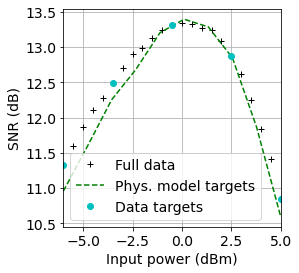

In [331]:
f, ax = plt.subplots()
plt.plot(pch_shifted, snr, 'k+', label='Full data')
plt.plot(pch_gn_shifted, snr_phys, 'g--', label='Phys. model targets')
plt.plot(pch_sub_shifted, snr_sub, 'co', label='Data targets')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.yticks([10,10.5,11,11.5,12, 12.5, 13, 13.5])
#plt.ylim([12, 13.6])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.grid()
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Plot the physical model against measured data.

In [332]:
pch_test = np.copy(pch_gn_shifted).reshape(-1,1)
snr_phys_test = np.copy(snr_phys).reshape(-1,1)

In [333]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub_shifted, pch_test, snr_sub, snr_phys_test, pch_shifted)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [334]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub_shifted, snr_sub, pch_shifted)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [335]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_standard_gp(pch_shifted, snr, pch_shifted)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

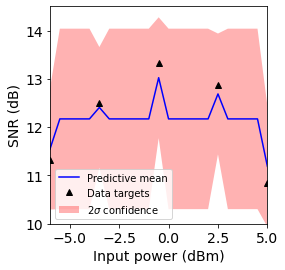

In [337]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_sub_shifted, snr_sub,'k^', label = 'Data targets')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
#plt.xticks([-5.5, -3.5, -1.5, 0.5, 2.5, 4.5])
plt.ylim([10,14.5])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc=3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/comp_standard_gppvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

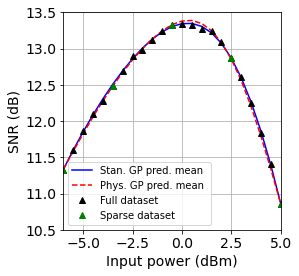

In [338]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_f, 'b-', label = 'Stan. GP pred. mean ')
ax.plot(pch_shifted, mu_sk_phys, 'r--', label = 'Phys. GP pred. mean')
ax.plot(pch_shifted, snr,'k^', label = 'Full dataset')
ax.plot(pch_sub_shifted, snr_sub,'g^', label = 'Sparse dataset')
# ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
#             np.concatenate([mu_sk_p2_f,
#                             (mu_sk_n2_f)[::-1]]),
#             alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
#plt.xticks([-5.5, -3.5, -1.5, 0.5, 2.5, 4.5])
plt.ylim([10.5,13.5])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
#plt.savefig('figures/comp_standard_gp_full_pvar05.pdf', dpi=200,bbox_inches='tight')
plt.show()

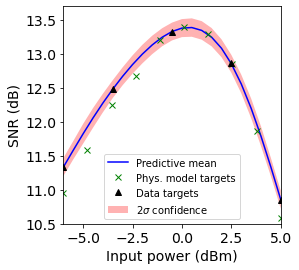

In [339]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub_shifted, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, phys_model_snr_plt, 'k:', label = 'Phys. model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4])
#plt.xticks([-5.5, -3.5, -1.5, 0.5, 2.5, 4.5])
plt.ylim([10.5,13.7])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/comp_gn_enhanced_gp_pvar05.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_gn_enhanced_gp_009.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_gn_enhanced_gp_001.pdf', dpi=200,bbox_inches='tight')
plt.show()

/Users/joshnevin/physical_gps/gn_model.py:67: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(x)


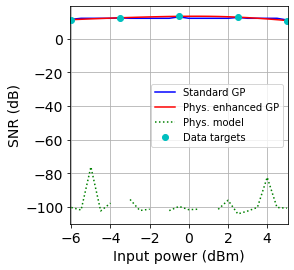

In [340]:
phys_model_snr_plt = phys_model.predict_snr(pch_shifted)
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'Standard GP')
#ax.plot(pch_shifted, mu_sk_f, 'g--', label = 'Standard GP all data')
ax.plot(pch_shifted, mu_sk_phys, 'r-', label = 'Phys. enhanced GP')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_shifted, phys_model_snr_plt, 'g:', label = 'Phys. model')
ax.plot(pch_sub_shifted, snr_sub,'co', label = 'Data targets')
#ax.plot(pch_shifted, snr,'k+', label='Full data set')
plt.xlim([pch_shifted[0]-0.05, pch_shifted[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Predictive mean comparison")
plt.legend(prop={'size':10})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/comp_pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_pred_mean_comp_full.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/comp_pred_mean_comp_physmod.pdf', dpi=200,bbox_inches='tight')
plt.show()

Compare MSE w.r.t. data for the physical model enhanced GP trained on subset of the data and standard GP trained on full dataset.

In [341]:
mse_phys = np.mean(((snr - mu_sk_phys)**2)**0.5)
mse_phys

0.8293754696397216

In [342]:
mse_stan_f = np.mean(((snr - mu_sk_f)**2)**0.5)
mse_stan_f

0.8149900630321978

In [343]:
100*(mse_phys - mse_stan_f)/mse_stan_f

1.7651020865214562

In [344]:
mse_phys - mse_stan_f

0.014385406607523854

Only 1% relative difference, or 0.01 dB error, in the MSE between the physics-enhanced GP and the standard GP trained on the full dataset! 

In [345]:
max(std_sk_f)

array([0.02961314])

In [346]:
max(std_sk_phys)

array([0.07257624])

Relative change in the predictive std (%):

In [347]:
100*(max(std_sk_phys) - max(std_sk_f))/max(std_sk_f)

array([145.08120298])

RMSD of the predictive mean of the model with and without physical models:

In [39]:
np.mean(((mu_sk_f - mu_sk_phys)**2)**0.5)

0.014438799174606085

Mean relative difference (%):

In [40]:
np.mean(100*(mu_sk_f - mu_sk_phys)/mu_sk_f)

0.037757229338730276

In [41]:
np.exp(theta_f)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([5.78455149e+01, 6.75189288e+00, 9.52350326e-04])

In [42]:
np.exp(theta_phys)

array([2.30029622e+01, 6.23532517e+00, 2.58695696e-04])